In [1]:
from opty import Problem, create_objective_function, parse_free
import sympy as sp
import numpy as np
import scipy as sc
import time
import pickle
import sympy.physics.mechanics as me
import sys
sys.path.insert(0, "..")
from importlib import reload

In [2]:
import equations as eq
reload (eq);
model_struct = sc.io.loadmat('../das3_simplified_quat.mat')
data_struct = sc.io.loadmat('../data_model_python2.mat')
initPosQuat = 'InitPosOptQuat'
start = time.time()
MM,FO,TE,q,w,fr,frstar,kindeq,xdot,constraints,activations = eq.create_eoms(model_struct,data_struct,initPosQuat,derive = 'numeric')
# q,w,fr,frstar,kindeq, Torques = eq.create_eoms(model_struct,data_struct,initPosQuat,derive = 'numeric')

time_to_create = time.time() - start
print(time_to_create)

308.98486733436584


In [3]:
import equations as eq
reload (eq);
data_struct = sc.io.loadmat('../data_model_python2.mat')
initPosQuat = 'InitPosOptQuat'
dict_vals,symlist, value_list = eq.create_parameters_dict(data_struct, initPosQuat)
x0 = data_struct['params']['InitPosOptQuat'][0,0]['initCondQuat'].item()
x0t = list(x0.T[0])

In [4]:
missing = [20,31,32,33]
activations.pop(33)
activations.pop(32)
activations.pop(31)
activations.pop(20)

act_21(t)

In [5]:
# ## ODE simulation ##

# force_lam = sp.lambdify(q + w, FO, cse=True)
# te_lam = sp.lambdify(q + w + activations, TE, cse=True)
# mm_lam = sp.lambdify(q + w, MM, cse=True)

In [6]:
# def gradient(t, y, args):
#     y[0:4] = y[0:4]/np.linalg.norm(y[0:4])
#     y[4:8] = y[4:8]/np.linalg.norm(y[4:8])
#     y[8:12] = y[8:12]/np.linalg.norm(y[8:12])
    
#     right_hand = force_lam(*y) + te_lam(*y, *args)
#     sol = np.linalg.solve(mm_lam(*y), right_hand)
#     return np.array(sol).T[0]

# interval = 5.
# schritte = 10000 * int(interval)
# times = np.linspace(0., interval, schritte)
# t_span = (0., interval)
# x0 = data_struct['params']['InitPosOptQuat'][0,0]['initCondQuat'].item()
# x0t = list(x0.T[0])

# from scipy.integrate import odeint, solve_ivp
# state_traj = solve_ivp(gradient, t_span, x0t_new, t_eval = times, args=(np.zeros(len(activations)),), method='Radau')


# import matplotlib.pyplot as plt
# for i in range(13):
#     plt.plot(times, state_traj.y[i, :])

# plt.xlabel('t')
# plt.grid()
# plt.show()

# import matplotlib.pyplot as plt
# for i in range(13,22):
#     plt.plot(times, state_traj.y[i, :])

# plt.xlabel('t')
# plt.grid()
# plt.show()

# x0t_new = state_traj.y[:,-1]

In [7]:
eoms_implicit = sp.Matrix(kindeq).col_join(fr+frstar+TE)

In [8]:
duration = 2  # seconds
num_nodes = 101
interval_value = duration/(num_nodes - 1)
time = np.linspace(0.0, duration, num=num_nodes)

state_symbols = tuple(q+w)
num_states = len(state_symbols)
specified_symbols = tuple(activations)
# specified_symbols = tuple(Torques)
num_inputs = len(specified_symbols)
t = me.dynamicsymbols._t

In [9]:
# obj_torque = sum(sp.Matrix(activations).applyfunc(lambda e: e**2))
# obj_traj = 100 * sum((sp.Matrix(q)-sp.Matrix(x0[0:13])).applyfunc(lambda e: e**2))
# obj_func = sp.Integral(obj_torque+obj_traj,t)
# obj, obj_grad = create_objective_function(obj_func,
#                                           state_symbols,
#                                           specified_symbols,
#                                           tuple(),
#                                           num_nodes,
#                                           interval_value,
#                                           integration_method='midpoint')


In [10]:
# def obj_my(free):
#     min_obj = []
#     for i in range(13):
#         min_obj.append(interval_value * np.sum((free[i*num_nodes:(i+1)*num_nodes] - x0t[i]))**2)
        
#     min_act = 1 * interval_value * np.sum(free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
#     return  np.sum(min_obj) + min_act #

# def obj_grad_my(free):
#     grad = np.zeros_like(free)
#     for i in range(13):
#         grad[i*num_nodes:(i+1)*num_nodes] = 2.0 * interval_value * (x0t[i] - free[i*num_nodes:(i+1)*num_nodes] )
#     grad[num_states*num_nodes:(num_states + num_inputs)*num_nodes] = 1 * 2.0 * interval_value * free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]
#     return grad

In [11]:
traj, init_guess = eq.das_trajectory(data_struct, num_nodes, duration, 0.5)

def obj(free):
    min_traj = 100 * interval_value * np.sum((traj - free[:13*num_nodes])**2)
    min_vel = 0.1 * interval_value * np.sum((free[13*num_nodes:num_states*num_nodes])**2)
    min_torque = 0.2 * interval_value * np.sum(free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
    return min_traj + min_torque + min_vel

def obj_grad(free):
    grad = np.zeros_like(free)
    grad[:13*num_nodes] = 100 * 2.0 * interval_value * (free[:13*num_nodes] - traj)
    grad[13*num_nodes:num_states*num_nodes] = 0.1 * 2 * interval_value * free[13*num_nodes:num_states*num_nodes]
    grad[num_states*num_nodes:(num_states + num_inputs)*num_nodes] = 0.2 * 2.0 * interval_value * free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]
    return grad

In [12]:
print(np.max(init_guess))

0.9988960616987123


In [13]:
instance_constraints = []
for i in range(13):
    instance_constraints.append(state_symbols[i].func(0.0)-x0t[i])
    
    
for i in time:
    normQ1 = q[0].func(i)**2+q[1].func(i)**2+q[2].func(i)**2+q[3].func(i)**2-1
    normQ2 = q[4].func(i)**2+q[5].func(i)**2+q[6].func(i)**2+q[7].func(i)**2-1
    normQ3 = q[8].func(i)**2+q[9].func(i)**2+q[10].func(i)**2+q[11].func(i)**2-1
    instance_constraints.append(normQ1)
    instance_constraints.append(normQ2)
    instance_constraints.append(normQ3)

    

# # bounds = (-3,3)*len(w)
# # bndrs = dict(zip(w,bounds))
bounds1 = (0.0,2)
bounds = (bounds1,)*len(activations)
bndrs = dict(zip(activations,bounds))

In [14]:
prob = Problem(obj, obj_grad, eoms_implicit, state_symbols,
               num_nodes, interval_value,
               known_parameter_map={},
               instance_constraints=instance_constraints,
               bounds=bndrs,
               integration_method='midpoint'
) #               


In [15]:
# feas_tol = 1e-5
prob.add_option('max_iter',10000)
# prob.add_option('acceptable_tol', feas_tol)
# prob.add_option('tol', feas_tol)
# prob.add_option('constr_viol_tol', feas_tol)
# prob.add_option('bound_frac', 0.001)
# prob.add_option('mu_strategy', 'adaptive')
prob.add_option('limited_memory_max_history', 40)
# prob.add_option('acceptable_constr_viol_tol', feas_tol)
# prob.add_option('nlp_scaling_method', 'None')

In [16]:
initial_guess = np.zeros(prob.num_free)
initial_guess[:13*num_nodes] = traj

In [18]:
solution, info = prob.solve(initial_guess)
print(info['status_msg'])
print(info['obj_val'])

b'Algorithm converged to a point of local infeasibility. Problem may be infeasible.'
0.5214351240974012


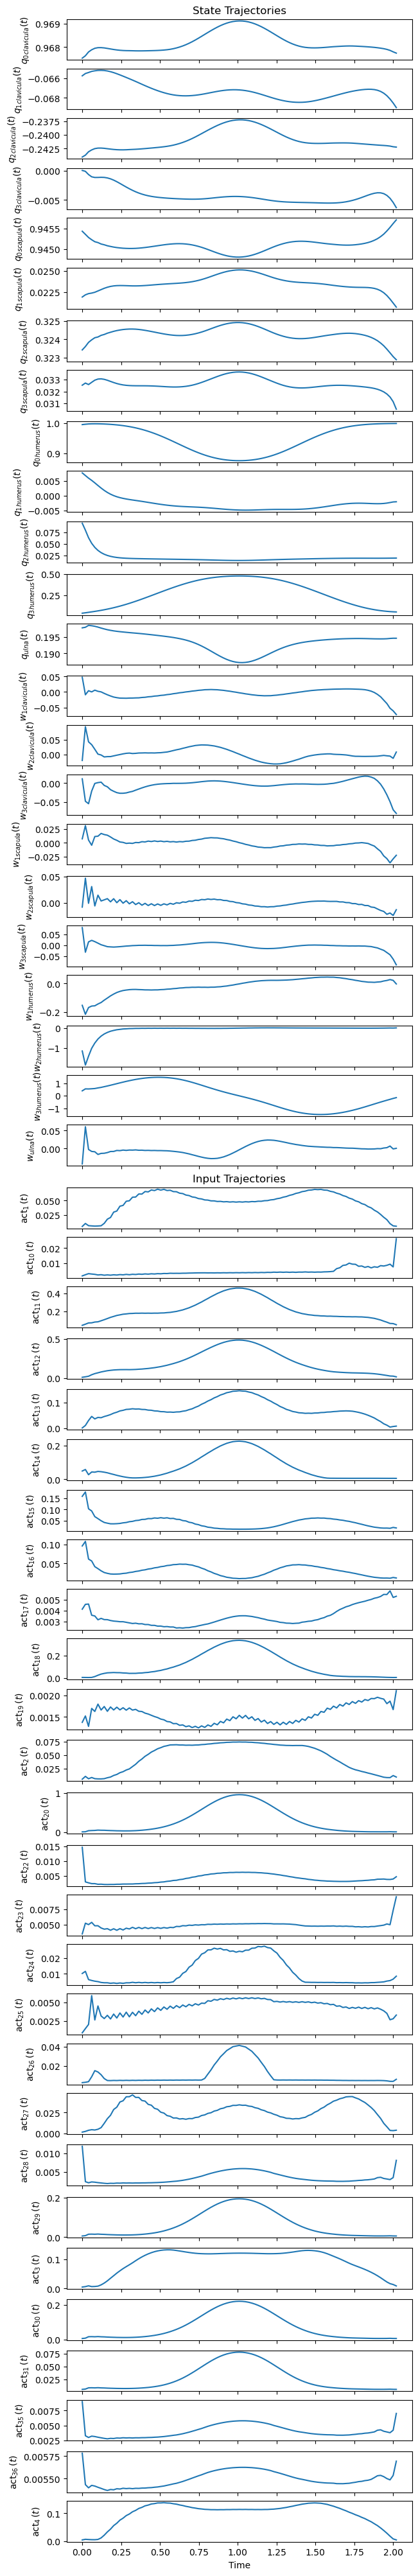

In [19]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(50, 1, sharex=True,
                         figsize=(6.4, 0.8*50),
                         layout='compressed')
prob.plot_trajectories(solution, axes=axes)

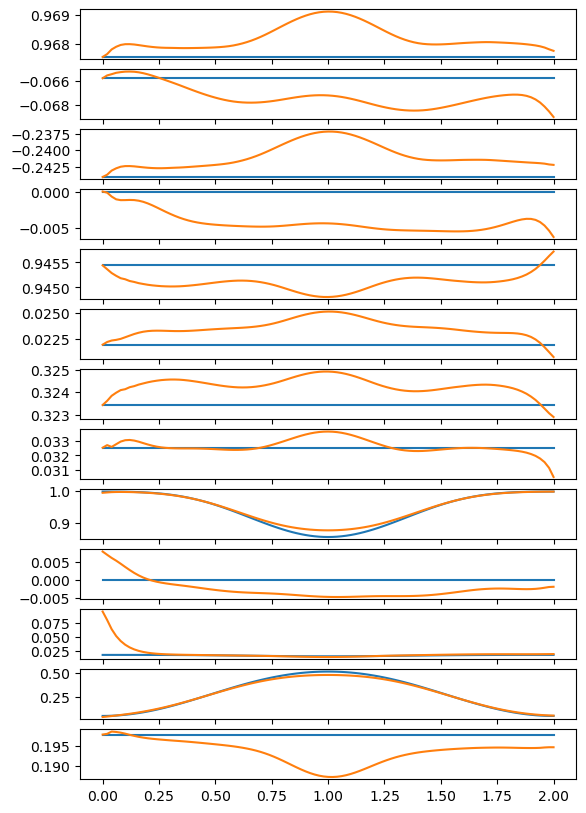

In [20]:
fig, axs = plt.subplots(13)
for j in range(13):
    axs[j].plot(time,traj[j*num_nodes:(j+1)*num_nodes])
    axs[j].plot(time,solution[j*num_nodes:(j+1)*num_nodes])
    fig.set_figheight(10)

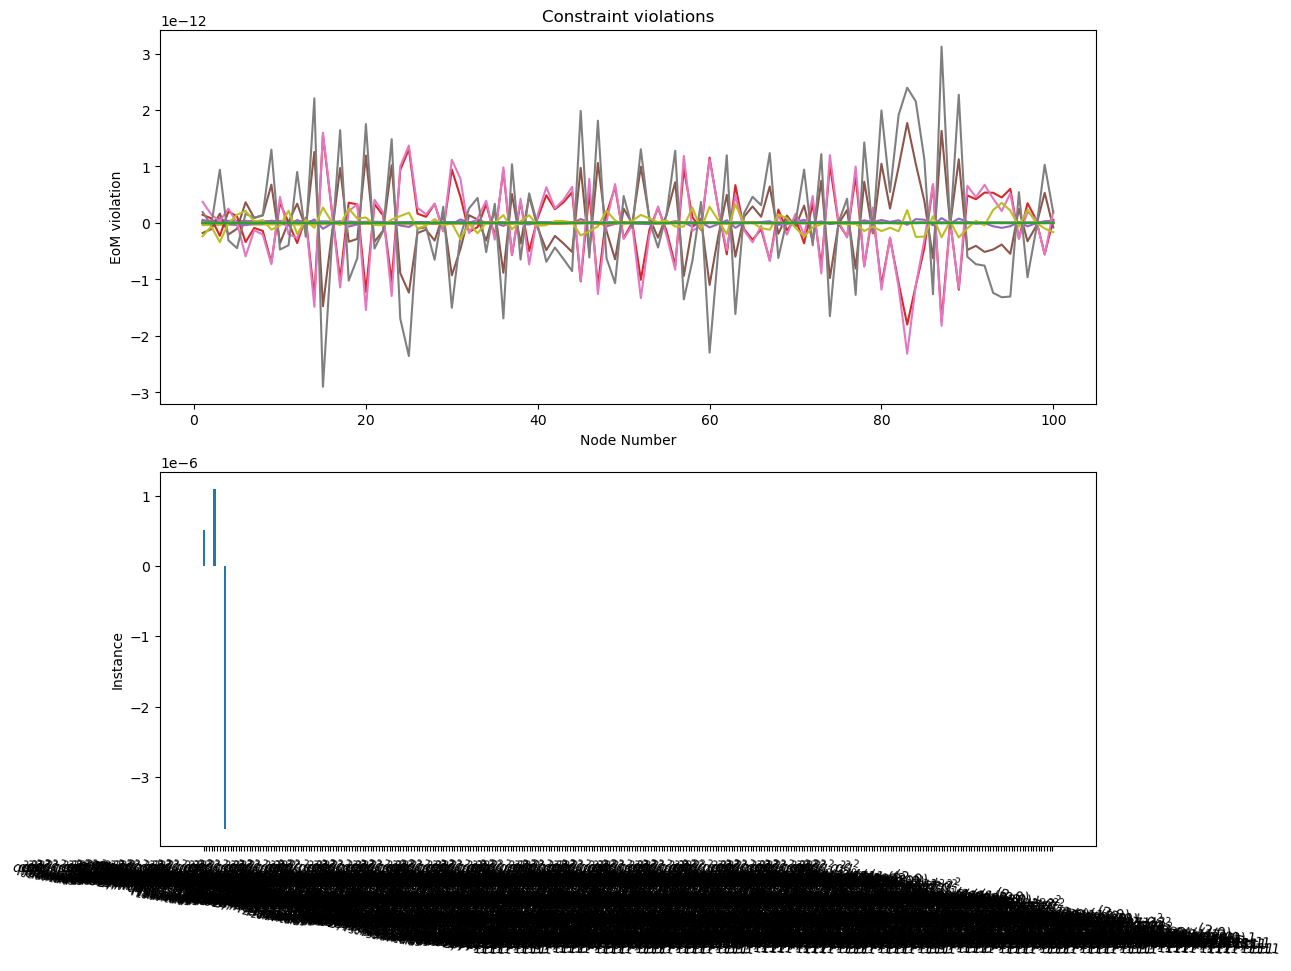

In [21]:
fig, axes = plt.subplots(2, figsize=(12.8, 9.6),
                         layout='constrained')
prob.plot_constraint_violations(solution, axes=axes)